In [1]:
ls

Aggregation.txt              Compound.txt              R15.txt50frames.gif
Aggregation.txt12frames.gif  Compound.txt22frames.gif  R15.txt60frames.gif
Aggregation.txt20frames.gif  D31.txt                   R15.txt80frames.gif
Aggregation.txt22frames.gif  D31.txt22frames.gif       README.md
Aggregation.txt3frames.gif   jain40frames.mp4          spiral20frames.mp4
animation-400.mp4            jain.txt                  spiral40frames.mp4
animation-b.mp4              jain.txt20frames.gif      spiral.txt
animation-c.mp4              pogo.ipynb                spiral.txt20frames.gif
animation-d.mp4              R15.txt                   spiral.txt5frames.gif
animation.gif                R15.txt22frames.gif
animation.mp4                R15.txt40frames.gif


In [2]:
import numpy as np
import pandas as pd
import gudhi

In [3]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from matplotlib.collections import PatchCollection

In [4]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits


from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics

import os.path

In [5]:
from urllib.request import urlopen
from urllib.parse import urlparse

In [84]:
%matplotlib inline

#randomized blobs with standard deviation
n = 6
std = np.random.random_sample((n,))
#std = 1
X, y, z = make_blobs(
    n_samples=n*100,
    n_features=2,
    centers=n,
    cluster_std=std,
    center_box=(-10.0, 10.0),
    shuffle=False,
    random_state=42,
    return_centers=True,
)



size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [7]:
urls = ['https://cs.joensuu.fi/sipu/datasets/D31.txt','https://cs.joensuu.fi/sipu/datasets/overlap.txt', 'https://cs.joensuu.fi/sipu/datasets/pathbased.txt','https://cs.joensuu.fi/sipu/datasets/a1.txt','https://cs.joensuu.fi/sipu/datasets/R15.txt','https://cs.joensuu.fi/sipu/datasets/unbalance.txt']

In [8]:
url= urls[4]
print(url)
parse = urlparse(url)
filename = parse.path.strip('/').split('/')[-1]
raw_data = urlopen(url)
data = np.loadtxt(raw_data)

print(data.shape)
print(data[1:20])


https://cs.joensuu.fi/sipu/datasets/R15.txt
(600, 3)
[[10.35   9.768  1.   ]
 [10.098  9.988  1.   ]
 [ 9.73   9.91   1.   ]
 [ 9.754 10.43   1.   ]
 [ 9.836  9.902  1.   ]
 [10.238  9.866  1.   ]
 [ 9.53   9.862  1.   ]
 [10.154  9.82   1.   ]
 [ 9.336 10.456  1.   ]
 [ 9.378 10.21   1.   ]
 [ 9.712 10.264  1.   ]
 [ 9.638 10.208  1.   ]
 [ 9.518  9.956  1.   ]
 [10.236  9.91   1.   ]
 [ 9.4   10.086  1.   ]
 [10.196  9.746  1.   ]
 [10.138  9.828  1.   ]
 [10.062 10.26   1.   ]
 [10.394  9.984  1.   ]]


In [9]:
#iris = load_iris()
#X = iris.data
#y = iris.target

In [10]:
print(filename)

y = data[:,2]
print(y.shape)
X = data[:,:2]
print(X.shape)
print(data)

R15.txt
(600,)
(600, 2)
[[ 9.802 10.132  1.   ]
 [10.35   9.768  1.   ]
 [10.098  9.988  1.   ]
 ...
 [13.636  5.218 15.   ]
 [14.41   4.656 15.   ]
 [14.02   5.614 15.   ]]


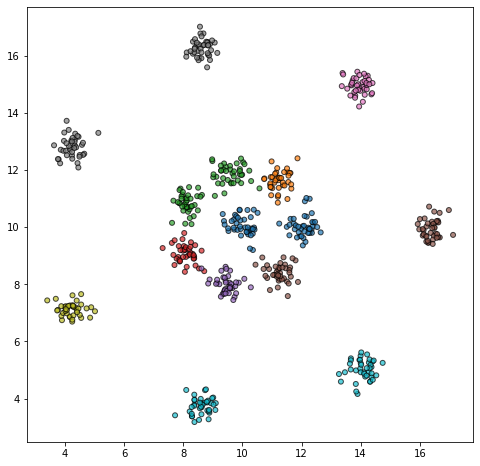

In [11]:
size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [12]:
rips_complex = gudhi.RipsComplex(points=X)


In [13]:

simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)


#for i in simplex_tree.get_filtration():
#    print(i)
    
print(simplex_tree.num_vertices() , 'vertices')  
print(simplex_tree.num_simplices(), 'simplices')
print('dimension:', simplex_tree.dimension())


600 vertices
180300 simplices
dimension: 1


In [14]:
diag = simplex_tree.persistence()

usetex mode requires TeX.


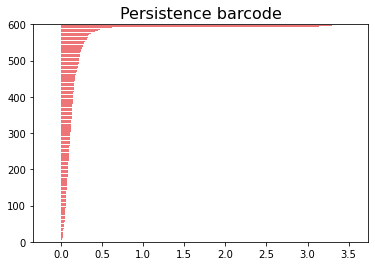

In [15]:
gudhi.plot_persistence_barcode(diag)
plt.show()

In [16]:
#move through list and assign clusters to conected components
point_dict={i:0 for i in range(simplex_tree.num_vertices())}
counter=0
cluster_dict_list = []

for simplex in simplex_tree.get_filtration():
    if len(simplex[0])>1:    
        if all(value > 0 for value in list(point_dict.values())):
            if len(np.unique(np.array(list(point_dict.values())))) == 1:
                print('break')
                print(simplex)
                print(simplex[1])
                simplex_tree.prune_above_filtration(simplex[1])
                break


        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[simplex[0][0]] == 0 and point_dict[simplex[0][1]] == 0:
            counter += 1
            point_dict[simplex[0][0]] = counter
            point_dict[simplex[0][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[simplex[0][0]] == 0 and point_dict[simplex[0][1]] != 0:
            point_dict[simplex[0][0]] = point_dict[simplex[0][1]]

            #and vice versa
        elif point_dict[simplex[0][0]] != 0 and point_dict[simplex[0][1]] == 0:
            point_dict[simplex[0][1]] = point_dict[simplex[0][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[simplex[0][0]] != 0 and point_dict[simplex[0][1]] != 0 and point_dict[simplex[0][0]] != point_dict[simplex[0][1]]:
            larger_cluster_number = max(point_dict[simplex[0][0]], point_dict[simplex[0][1]])
            smaller_cluster_number = min(point_dict[simplex[0][0]], point_dict[simplex[0][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
        cluster_dict_list.append(point_dict.copy())


break
([72, 278], 3.394113728206525)
3.394113728206525


In [17]:
len(np.unique(np.array(list(point_dict.values()))))

1

In [18]:
length = len(cluster_dict_list)
length

42270

In [19]:
print(simplex_tree.num_simplices(), 'simplices')


42871 simplices


In [20]:
print(cluster_dict_list[-2].values()) #penultimate clustering has 2 clusters
print(cluster_dict_list[-1].values()) #last clustering finally merges to all one cluster

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [21]:
#convert the simplex tree to a pandas dataframe
df = pd.DataFrame(simplex_tree.get_filtration(), columns=['simplex','distance'])

In [22]:
df = df[:len(cluster_dict_list)]
df

,simplex,distance
0,[0],0.000000
1,[1],0.000000
2,[2],0.000000
3,[3],0.000000
4,[4],0.000000
...,...,...
42265,"[133, 202]",3.348545
42266,"[220, 289]",3.348682
42267,"[45, 126]",3.348725
42268,"[58, 142]",3.348729


In [23]:
#find the gaps between birth/death pairs
df['gaps'] = df['distance'] - df['distance'].shift(1)

In [24]:
#find normalized distance
scaler = MinMaxScaler()
df['normed_distance'] = scaler.fit_transform(df['distance'].values.reshape(-1, 1))

In [25]:
df

,simplex,distance,gaps,normed_distance
0,[0],0.000000,NaN,0.000000
1,[1],0.000000,0.000000,0.000000
2,[2],0.000000,0.000000,0.000000
3,[3],0.000000,0.000000,0.000000
4,[4],0.000000,0.000000,0.000000
...,...,...,...,...
42265,"[133, 202]",3.348545,0.000016,0.999937
42266,"[220, 289]",3.348682,0.000137,0.999978
42267,"[45, 126]",3.348725,0.000043,0.999991
42268,"[58, 142]",3.348729,0.000004,0.999992


In [26]:
df['inverted_normed_distance'] = 1 - df['normed_distance']

In [27]:
df

,simplex,distance,gaps,normed_distance,inverted_normed_distance
0,[0],0.000000,NaN,0.000000,1.000000
1,[1],0.000000,0.000000,0.000000,1.000000
2,[2],0.000000,0.000000,0.000000,1.000000
3,[3],0.000000,0.000000,0.000000,1.000000
4,[4],0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...
42265,"[133, 202]",3.348545,0.000016,0.999937,0.000063
42266,"[220, 289]",3.348682,0.000137,0.999978,0.000022
42267,"[45, 126]",3.348725,0.000043,0.999991,0.000009
42268,"[58, 142]",3.348729,0.000004,0.999992,0.000008


In [28]:
df['normed_gaps'] = df['gaps'] * df['normed_distance']

In [29]:
df['inverted_normed_gaps'] = df['gaps'] * df['inverted_normed_distance']

In [30]:
normed_gap_sum = df['normed_gaps'].sum()
#print(sum)
df['probability_vector'] = df['normed_gaps'] / normed_gap_sum

In [31]:
inverted_gap_sum = df['inverted_normed_gaps'].sum()
#print(sum)
df['inverted_gap_vector'] = df['inverted_normed_gaps'] / inverted_gap_sum

In [32]:
gap_sum = df['gaps'].sum()
#print(sum)
df['gap_vector'] = df['gaps'] / gap_sum

In [33]:
df['probability_vector'][1:]

1        0.000000
2        0.000000
3        0.000000
4        0.000000
5        0.000000
           ...   
42265    0.000010
42266    0.000082
42267    0.000026
42268    0.000002
42269    0.000016
Name: probability_vector, Length: 42269, dtype: float64

In [34]:
sum(df['probability_vector'][1:])

0.9999999999999986

In [35]:
sum(df['gap_vector'][1:])

0.9999999999999896

In [36]:
sum(df['inverted_gap_vector'][1:])

1.0000000000000102

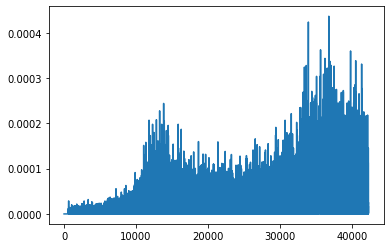

In [37]:
plt.plot(df['probability_vector'])

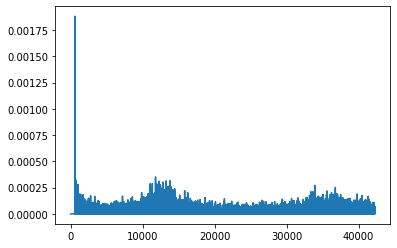

In [38]:
plt.plot(df['gap_vector'])

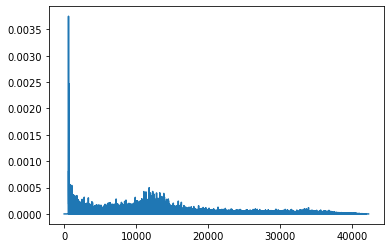

In [39]:
plt.plot(df['inverted_gap_vector'])

In [40]:
cluster_dict_list[0].values()

dict_values([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [41]:
df.columns

Index(['simplex', 'distance', 'gaps', 'normed_distance',
       'inverted_normed_distance', 'normed_gaps', 'inverted_normed_gaps',
       'probability_vector', 'inverted_gap_vector', 'gap_vector'],
      dtype='object')

In [42]:
marker = 0
for i in range(1,length-1):
    if cluster_dict_list[marker] == cluster_dict_list[i]:

        df.iloc[marker,7] += df.iloc[i,7]
        df.iloc[i,7] = 0
                
        df.iloc[marker,8] += df.iloc[i,8]
        df.iloc[i,8] = 0
                
        df.iloc[marker,9] += df.iloc[i,9]
        df.iloc[i,9] = 0
        #print(marker)


    else:
        marker = i

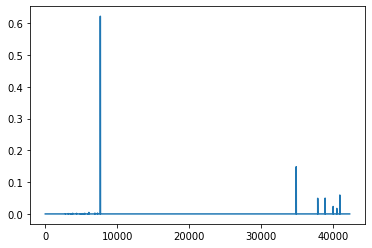

In [43]:
plt.plot(df['probability_vector'])

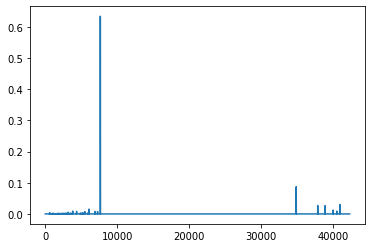

In [44]:
plt.plot(df['gap_vector'])

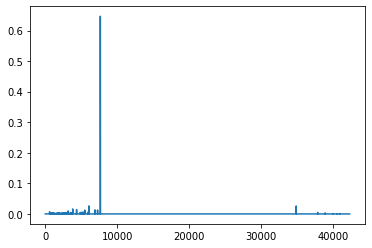

In [45]:
plt.plot(df['inverted_gap_vector'])

In [46]:
candidates = list(df.nlargest(length,['inverted_gap_vector']).index)

In [47]:
candidates

[7643,
 6053,
 34848,
 3807,
 4346,
 6889,
 7259,
 5481,
 3187,
 601,
 5236,
 4962,
 5887,
 37832,
 3481,
 1903,
 2781,
 4837,
 3613,
 2606,
 2452,
 38864,
 3018,
 1171,
 627,
 639,
 2933,
 2380,
 1082,
 1009,
 1708,
 2315,
 5160,
 2244,
 837,
 1617,
 3744,
 955,
 619,
 635,
 977,
 1872,
 1222,
 2145,
 703,
 1575,
 1062,
 2066,
 1655,
 608,
 1045,
 1754,
 1815,
 1341,
 714,
 914,
 881,
 2708,
 4297,
 757,
 1377,
 2567,
 2116,
 3112,
 3145,
 597,
 1254,
 606,
 1277,
 799,
 824,
 872,
 898,
 2034,
 3452,
 39976,
 1513,
 929,
 1533,
 995,
 2208,
 1493,
 811,
 1323,
 1851,
 1452,
 776,
 40905,
 1776,
 668,
 1140,
 1788,
 1392,
 751,
 766,
 1422,
 2739,
 699,
 2896,
 1118,
 1243,
 654,
 785,
 1683,
 2541,
 1409,
 732,
 1128,
 728,
 2297,
 2019,
 656,
 2920,
 650,
 686,
 744,
 2759,
 2099,
 40485,
 662,
 1003,
 1805,
 941,
 642,
 736,
 1303,
 1568,
 2185,
 2195,
 1610,
 672,
 617,
 1476,
 1316,
 792,
 1275,
 1156,
 2596,
 676,
 722,
 1442,
 857,
 614,
 1437,
 2234,
 688,
 696,
 1651,
 1485,


In [48]:
idx = candidates[0]
idx

7643

In [120]:
print(df.loc[:,'gap_vector'][idx])
print('percent confidence')
'{:.1%}'.format(df.loc[:,'gap_vector'][idx])

0.0024573138089380997
percent confidence


'0.2%'

In [121]:
np.array(list(cluster_dict_list[idx].values()))

array([  9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,
         9,   9,   9,   9,   9,   9,   9,   9,   9,   9, 143,   9,   9,
         9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,
       143,  19,  19,  19,  19,  19,  19,  19,  19,  19,  19,  19, 147,
        19,  19,  19,  19,  19,  19,  19,  19,  19,  19,  19,  19,  19,
       147,  19,  19, 147,  19,  19,  19,  19,  19,  19,  19,  19,  19,
        19,  19,   7,   7,   7,   7,   7,   7,   7,   0,   7,   7,   7,
         7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
         7,   7,   7,   7,   7,   7,   7,   0,   7,   7,   7,   7,   7,
         7,   7,   7,   1,   1,   1,   1,   1,   1,   0,   0,   1,   1,
         1,   1,  85,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         0,   1,   1,   1,   1,   1,  85,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   0,   5,   5,   5,   5,   5,   5,   5,   5,   5,
         5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   

In [122]:
#cluster_idx_array = (np.unique(np.array(list(cluster_dict_list[idx].values()))))
#print(cluster_idx_array)
#print(np.count_nonzero(cluster_idx_array))

number_of_clusters = np.count_nonzero(np.unique(np.array(list(cluster_dict_list[idx].values()))))
print(number_of_clusters)
print('your dataset appears to have', number_of_clusters,'clusters, not including any outliers')
#return counts from np.unique? to filter out small clusters?

21
your dataset appears to have 21 clusters, not including any outliers


In [123]:
true = y
pred = np.array(list(cluster_dict_list[idx].values()))

print(metrics.adjusted_rand_score(true, pred))
print(metrics.silhouette_score(X, pred, metric="sqeuclidean"))

0.9402441277383992
0.6818774823663606


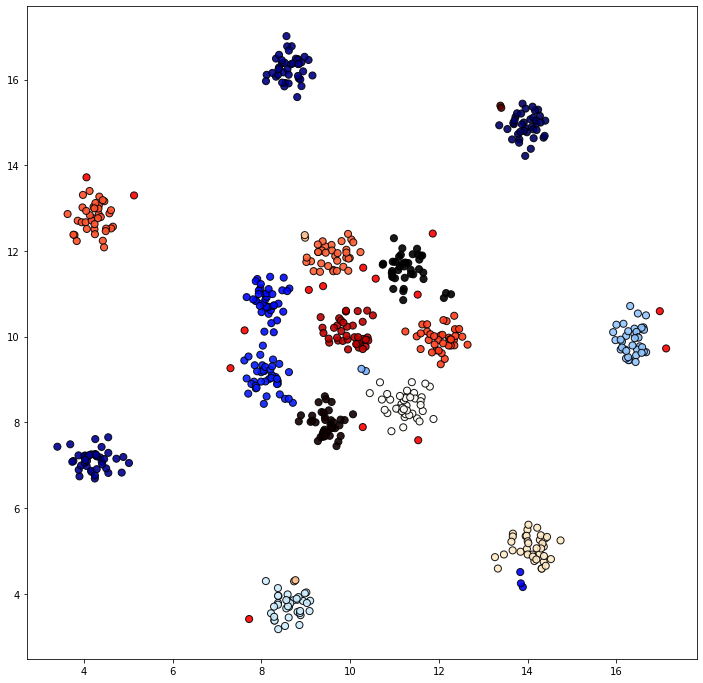

In [124]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=np.array(list(cluster_dict_list[idx].values())),
            marker="o",
            cmap='flag',
            norm=None,
            alpha=.9,
            edgecolor="k")

In [125]:
idx_list = candidates[:50]

In [55]:
idx_list.sort()

In [112]:
idx_list = [x for x in idx_list if x < idx]

In [113]:
idx_array = np.asarray(idx_list)
idx_array

array([ 601,  608,  619,  627,  635,  639,  703,  837,  955,  977, 1009,
       1062, 1082, 1171, 1222, 1575, 1617, 1655, 1708, 1872, 1903, 2066,
       2145, 2244, 2315, 2380, 2452, 2606, 2781, 2933, 3018, 3187, 3481,
       3613, 3744, 3807])

In [114]:
silhouette_list = []
for i in idx_list:
    silhouette = metrics.silhouette_score(X, np.array(list(cluster_dict_list[i].values())), metric="euclidean")
    silhouette_list.append(silhouette)

In [115]:
silhouette_array = np.asarray(silhouette_list)

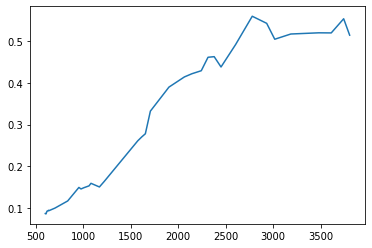

In [116]:
plt.plot(idx_array,silhouette_array)

In [117]:
max(silhouette_array)

0.5599535646351718

In [118]:
max_idx = silhouette_array.argmax()

In [119]:
idx = idx_array[max_idx]
idx

2781

In [64]:
#idx = silhouette_scores.index(max(silhouette_scores[simplex_tree.num_vertices():idx]))
#print(idx)

In [65]:
rand_score_list = []
true = y
for i in idx_list:
    pred = np.array(list(cluster_dict_list[i].values()))
    rand_score = metrics.adjusted_rand_score( true, pred)
    rand_score_list.append(rand_score)

In [66]:
rand_score_array = np.asarray(rand_score_list)

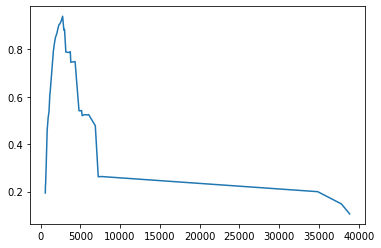

In [67]:
 plt.plot(idx_array,rand_score_array)

In [68]:
max(rand_score_array)

0.9402441277383992

In [69]:
np.where(rand_score_array == max(rand_score_array) )

(array([28]),)

In [70]:
#idx_array[31]

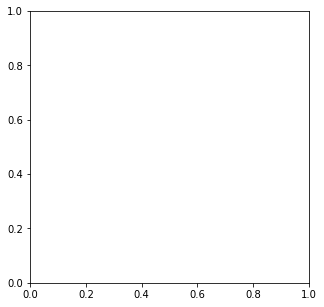

In [71]:
fig, ax = plt.subplots(figsize=(5,5))
frames = len(idx_array)


outfile = filename + str(frames) + 'frames.gif'

if not os.path.isfile(outfile):
    def init():
        scatter = ax.scatter(X[:, 0], X[:, 1],
                        s=40, 
                        c=np.array(list(cluster_dict_list[0].values())),
                        marker="o",
                        cmap='rainbow',
                        norm=None,
                        alpha=1,
                        edgecolor="k")
        #ax.set(xlim=(-1, 35), ylim=(-1, 35))

        return scatter,

    #collection = PatchCollection(X, animated=True)

    #ax.add_collection(collection)
    #ax.autoscale_view(True)

    def animate(i):

        scatter = ax.scatter(X[:, 0], X[:, 1],
                    s=40, 
                    c=np.array(list(cluster_dict_list[idx_array[i]].values())),
                    marker="o",
                    cmap='flag',
                    norm=None,
                    alpha=1,
                    edgecolor="k")
        return scatter,



    ani = FuncAnimation(fig, animate,interval=200,init_func=init,frames=frames,repeat=False, blit=True)

    #ani.save('animation.gif')



    #writer=animation.PillowWriter()

    #writer = animation.FFMpegWriter(fps=2,bitrate=1000)

    ani.save(outfile, dpi=200)
    fig.show()


In [72]:
def pogo(dataset):
    rips_complex = gudhi.RipsComplex(points=dataset,max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
    df = pd.DataFrame(simplex_tree.get_filtration(), columns=['simplex','distance'])
    #move through list and assign clusters to conected components

    point_dict={i:0 for i in range(simplex_tree.num_vertices())}
    counter=0

    cluster_dict_list = []
    for i in range(simplex_tree.num_vertices(),len(df)):
        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            counter += 1
            point_dict[df.loc[i,'simplex'][0]] = counter
            point_dict[df.loc[i,'simplex'][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] != 0:
            point_dict[df.loc[i,'simplex'][0]] = point_dict[df.loc[i,'simplex'][1]]

            #and vice versa
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            point_dict[df.loc[i,'simplex'][1]] = point_dict[df.loc[i,'simplex'][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] != 0 and point_dict[df.loc[i,'simplex'][0]] != point_dict[df.loc[i,'simplex'][1]]:
            larger_cluster_number = max(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            smaller_cluster_number = min(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
        cluster_dict_list.append(point_dict.copy())
        #print(point_dict)
        #print('step',i)

    
    cutoff_value = 0
    for i in range(len(cluster_dict_list)):
        if cutoff_value == 0:
            if all(value != 0 for value in cluster_dict_list[i].values()):
                cutoff_value = i
                print('dataset becomes connected at simplex #',cutoff_value)
       
    df = df[:cutoff_value]
    #cluster_dict_list =
    
    #find the gaps between birth/death pairs

    df['gaps'] = df['distance'] - df['distance'].shift(1)
    
    #find normalized distance
    scaler = MinMaxScaler()
    df['normed_distance'] = scaler.fit_transform(df['distance'].values.reshape(-1, 1))

    #Mulitply the gaps by their normed location in the filtration, weighting features more heavily if they're later
    df['normed_gaps'] = df['gaps'] * df['normed_distance']

    norm_sum = df['normed_gaps'].sum()
    df['probability_vector_normed_gaps'] = df['normed_gaps'] / norm_sum
    
    gap_sum = df['gaps'].sum()
    df['probability_vector_gaps'] = df['normed_gaps'] / gap_sum

    partition = 10
    candidates = [i for i in df.nlargest(partition ,['gaps']).index if i in df.nlargest( partition,['normed_gaps']).index]
    #print('possible cuttoffs' , candidates)
    idx = cutoff_value - 1
    #idx = candidates[0]
    print('idx' ,idx)

    print('your dataset appears to have', len(np.unique(np.array(list(cluster_dict_list[idx].values())))),'clusters')

    #print( np.array(list(cluster_dict_list[idx].values())))

    print(simplex_tree.num_vertices() , 'vertices')  
    print(simplex_tree.num_simplices(), 'simplices')
    print('dimension:', simplex_tree.dimension())

    size=10
    plt.figure(figsize=(size,size))
    plt.scatter(dataset[:, 0], dataset[:, 1],
                s=30, 
                c=np.array(list(cluster_dict_list[idx].values())),
                marker="o",
                cmap='rainbow',
                norm=None,
                alpha=.9,
                edgecolor="k")
    
    return cluster_dict_list, candidates, idx


dataset becomes connected at simplex # 7643
idx 7642
your dataset appears to have 9 clusters
600 vertices
180300 simplices
dimension: 1


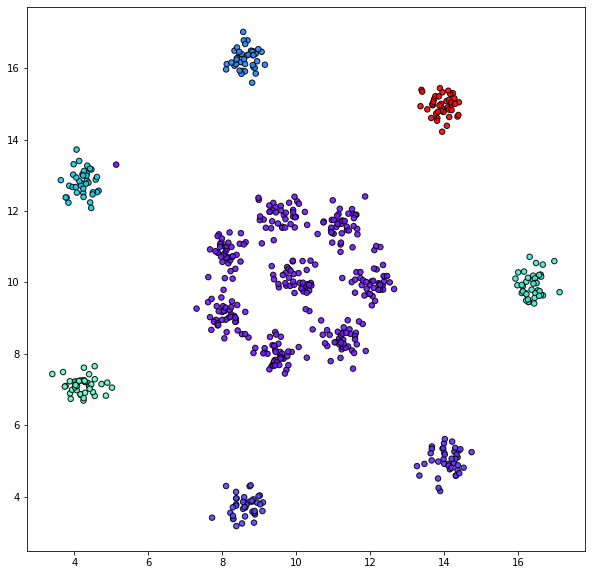

In [73]:
cluster_dict_list, candidates, idx = pogo(X)

In [74]:
true = y
pred = np.array(list(cluster_dict_list[idx].values()))

print('adjusted rand score =' , metrics.adjusted_rand_score(true, pred))


adjusted rand score = 0.2626233713529096


In [75]:
#%matplotlib notebook

In [76]:
frames = 30
interval = int(len(cluster_dict_list)/frames)
print(interval)


5990


<IPython.core.display.Javascript object>


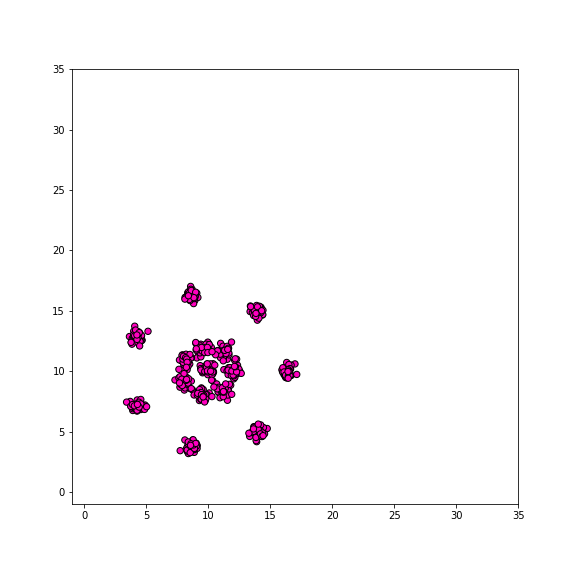

5990


In [77]:
fig, ax = plt.subplots(figsize=(8,8))
frames = 30
interval = int(len(cluster_dict_list)/frames)
print(interval)

scatter = ax.scatter(X[:, 0], X[:, 1],
                s=40, 
                c=np.array(list(cluster_dict_list[0].values())),
                marker="o",
                cmap='gist_rainbow',
                norm=None,
                alpha=1,
                edgecolor="k")
ax.set(xlim=(-1, 35), ylim=(-1, 35))

def animate(n):
    scatter.set_array(np.array(list(cluster_dict_list[n*interval].values())))
    
ani = FuncAnimation(fig, animate,interval=20,frames=frames,repeat=True, blit=True)

#ani.save('animation.gif')



writer=animation.PillowWriter()

writer = animation.FFMpegWriter(fps=2,bitrate=1000)

ani.save('animation-d.mp4', writer=writer, dpi=250)


fig.show()